# Adult Data Set Analisys

## Abstract
**About this Dataset**
US Adult Census data relating income to social factors such as Age, Education, race etc.

The Us Adult income dataset was extracted by Barry Becker from the 1994 US Census Database. The data set consists of anonymous information such as occupation, age, native country, race, capital gain, capital loss, education, work class and more. Each row is labelled as either having a salary greater than ">50K" or "<=50K".

This Data set is split into two CSV files, named adult-training.txt and adult-test.txt.

The goal here is to train a binary classifier on the training dataset to predict the column '__target__' which has two possible values ">50K" and "<=50K" and evaluate the accuracy of the classifier with the test dataset.

This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

USAGE This dataset is well suited to developing and testing wide linear classifiers, deep neutral network classifiers and a combination of both. For more info on Combined Deep and Wide Model classifiers, refer to the Research Paper by Google https://arxiv.org/abs/1606.07792

# What are we going to use ?

In [28]:
from pmlb import fetch_data, classification_dataset_names
# from Regressions.SGDClassifier_Solver import sgdcalssifier
# from Regressions.SupportVectorMachine_Solver import supportVectorMachine
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from scipy.stats import pointbiserialr, spearmanr
from sklearn.preprocessing import QuantileTransformer
import random
import numpy as np
import pandas as pd

# %load 

In [2]:
adult_data, adult_labels = fetch_data('adult', return_X_y=True, local_cache_dir='./')
adult_data_frame = fetch_data('adult')
# adult_data_frame.groupby("age")["target"].count().plot(kind='line')
# plt.show()

Data presented, with all if it's fetures. Some observations:
1. fnlwgt is a highly dispersive. We will leave it out for this test
2. All the values are already numerical, thanks to the pmlb library.

In [3]:
adult_data_frame.describe()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
count,48842.000000,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,3.870439,1.896641e+05,10.288420,10.078089,2.618750,6.577700,1.443287,3.668052,0.668482,1079.067626,87.502314,40.422382,36.749355,0.760718
std,13.710510,1.464234,1.056040e+05,3.874492,2.570973,1.507703,4.230509,1.602151,0.845986,0.470764,7452.019058,403.004552,12.391444,7.775343,0.426649
min,17.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,4.000000,1.175505e+05,9.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000,1.000000
50%,37.000000,4.000000,1.781445e+05,11.000000,10.000000,2.000000,7.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000,1.000000
75%,48.000000,4.000000,2.376420e+05,12.000000,12.000000,4.000000,10.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000,1.000000
max,90.000000,8.000000,1.490400e+06,15.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000,1.000000


In [4]:
feature_columns = ['age', 'workclass', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']
adult_data_frame = adult_data_frame[feature_columns]

Next we want to plot the correlation matrix of the data set. This will help us establish if there are some features that are more correlated than others. 

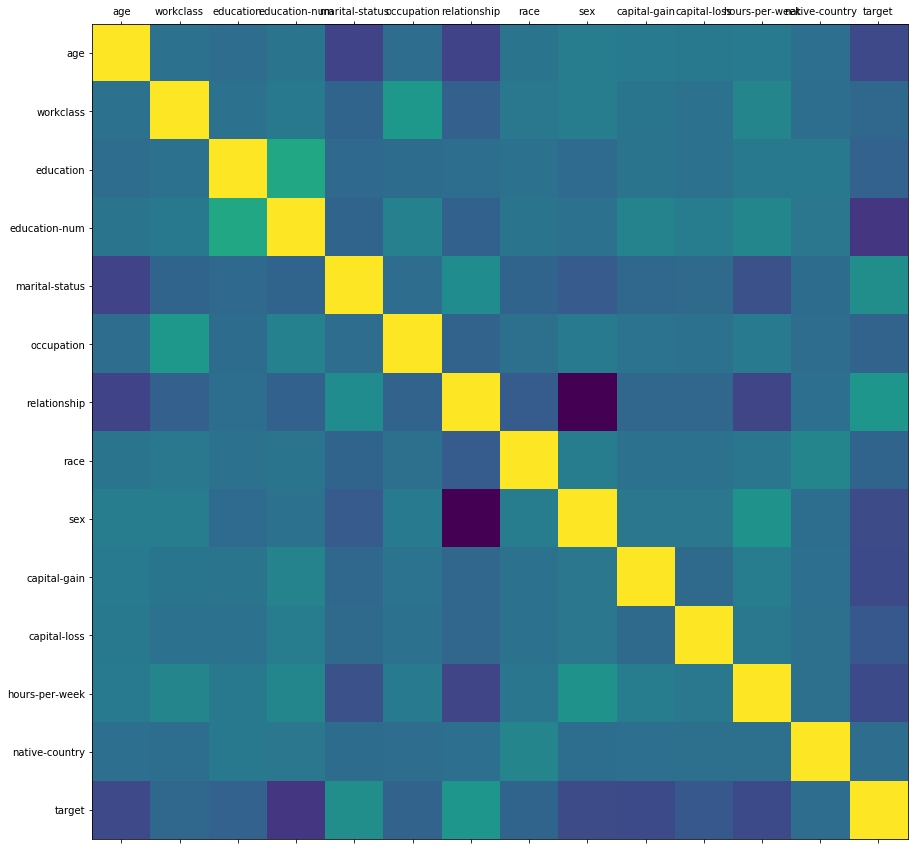

In [5]:
def plot_correlation(adult_data_frame, size=15):
    corr= adult_data_frame.corr()
    fig, ax =plt.subplots(figsize=(size,size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show()
plot_correlation(adult_data_frame)

In [6]:
param=[]
correlation=[]
abs_corr=[]

for c in feature_columns:
    #Check if binary or continuous
    if c != "target":
        if len(adult_data_frame[c].unique()) <= 2:
            corr = spearmanr(adult_data_frame['target'],adult_data_frame[c])[0]
        else:
            corr = pointbiserialr(adult_data_frame['target'],adult_data_frame[c])[0]
        param.append(c)
        correlation.append(corr)
        abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,correlation,abs_corr
parameter,,
education-num,-0.332613,0.332613
relationship,0.253214,0.253214
age,-0.230369,0.230369
hours-per-week,-0.227687,0.227687
capital-gain,-0.223013,0.223013
sex,-0.214628,0.214628
marital-status,0.199072,0.199072
capital-loss,-0.147554,0.147554
education,-0.080091,0.080091


At eye-sight, we observe that sex adn relationship status are higly correlated between each other. The same can be said about age:marital-status and age:relationship.

Regarding the target, we observe that education-num, relationship sex, capital-gain, and hours-per-week are highly correlated with our objective. Further analysis on theese features is required.

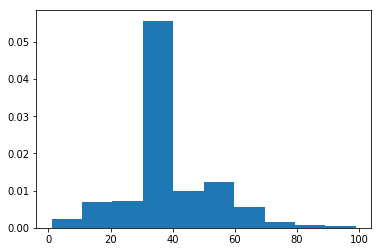

In [7]:
x= adult_data_frame['hours-per-week']
plt.hist(x,bins=None,density=True,normed=None,histtype='bar')
plt.show()

Unfortunatelly, hours per week doe

In the following table we are able to see the influence that the relationship status has on the targeted outcome. On the original dataset, the outliers, 0 and 9 are 'Husbands' and 'Wifes', therefore, couples, while the rest of the labels are 'Divorced' ,'Married-spouse-absent' ,'Never-married' ,'Separated', 'Widowed'.

In [8]:
adult_data_frame[['relationship','target']].groupby(['relationship']).mean()

,target
relationship,
0,0.551329
1,0.898593
2,0.965471
3,0.985358
4,0.939707
5,0.531103


Given the obvious difference between the Singles and Couples, we are going to alter the column so that we will only have the 'Single' and 'Couple' labels.

In [9]:
adult_data_frame[['marital-status','target']].groupby(['marital-status']).mean()
adult_data_frame['marital-status'] = adult_data_frame['marital-status'].replace([0,3,4,5,6],'Single')
adult_data_frame['marital-status'] = adult_data_frame['marital-status'].replace([1,2],'Couple')
adult_data_frame[['marital-status','target']].groupby(['marital-status']).mean()

,target
marital-status,
Couple,0.553979
Single,0.936086


In [10]:
adult_data_frame[['marital-status','relationship','target']].groupby(['relationship','marital-status']).mean()

target
relationship marital-status          
0            Couple          0.551329
1            Couple          0.782609
             Single          0.898806
2            Couple          0.856436
             Single          0.982362
3            Couple          0.826389
             Single          0.988436
4            Single          0.939707
5            Couple          0.531103

In [11]:
#Reverting the marital-status column back to a number.
b, c = np.unique(adult_data_frame['marital-status'], return_inverse=True) 
adult_data_frame['marital-status'] = c

In [12]:
X= adult_data_frame.drop(['target'],axis=1)
y= adult_data_frame['target']

#Creation of Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)

#Creation of Train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=5)

print ("Train dataset: {0}{1}".format(X_train.shape, y_train.shape))
print ("Validation dataset: {0}{1}".format(X_val.shape, y_val.shape))
print ("Test dataset: {0}{1}".format(X_test.shape, y_test.shape))

Train dataset: (27351, 13)(27351,)
Validation dataset: (6838, 13)(6838,)
Test dataset: (14653, 13)(14653,)


In [13]:
# import pandas as pd
# pd.crosstab(X_train['education'],y_train )

target,0,1
education,,
0,47,702
1,50,997
2,32,350
3,5,128
4,14,274
5,38,516
6,26,406
7,223,660
8,279,874


In [14]:
# adult_data_frame[['workclass','target']].groupby(['workclass']).sum()

,target
workclass,
0,2534
1,871
2,2209
3,10
4,26519
5,757
6,2785
7,1451
8,19


## Predictions
In making the predictions we are going to use multiple algorithms and try to identify the best one. 
Algorithms used are:
1. Random Forest Trees
2. Logistic Regression
3. Support Vector Machine 

### 1. Random Forest Trees

In [21]:
def RandomForestTrees(adult_data, adult_labels):
    tree_count = 10
    bag_proportion = 0.6
    predictions = []

    train_data, test_data, train_labels, test_labels = train_test_split(adult_data, adult_labels, test_size=0.2,
                                                                        random_state=random.randint(1, 99))
    
    #Scaling the data
    qt = QuantileTransformer(output_distribution='uniform')
    train_data = qt.fit_transform(train_data)
    test_data = qt.transform(test_data)

    for i in range(tree_count):
        # bag = train_data.sample(frac=bag_proportion, replace=True, random_state=i)
        X_train, X_test = train_data, test_data
        y_train, y_test = train_labels, test_labels
        clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=75)
        clf.fit(X_train, y_train)
        predictions.append(clf.predict_proba(X_test)[:, 1])

    combined = np.sum(predictions, axis=0) / 10
    rounded = np.round(combined)

    print('Accuracy:', accuracy_score(rounded, y_test))
    print('F1 score:', f1_score(rounded, y_test))

In [22]:
RandomForestTrees(X, y)

Accuracy: 0.8602722898966118
F1 score: 0.910999543587403


### 2. Support Vector Machines

In [26]:
def supportVectorMachine(adult_data, adult_labels):

    #Split Data
    train_data, test_data, train_labels, test_labels = train_test_split(adult_data, adult_labels, test_size=0.2,
                                                                        random_state=random.randint(1, 99))

    # Preprocess Data
    # This Scaler is used according to the results obtained in DataScalaionComparison for Logistical Regression
    qt = QuantileTransformer(output_distribution='uniform')
    train_data = qt.fit_transform(train_data)
    test_data = qt.transform(test_data)

    #Fit Machine
    LSVC = SVC(kernel='linear', random_state=0, tol=1e-5, C=0.1)
    LSVC.fit(train_data, train_labels)
    LSVC_prediction = LSVC.predict(test_data)

    rounded = np.round(LSVC_prediction)

    print('Accuracy:', accuracy_score(rounded, test_labels))
    print('F1 score:', f1_score(rounded, test_labels))

    PolySVM = SVC(kernel='poly')
    PolySVM.fit(train_data, train_labels)
    PolySVM_prediction = PolySVM.predict(test_data)
    
    rounded = np.round(PolySVM_prediction)

    print('Accuracy:', accuracy_score(rounded, test_labels))
    print('F1 score:', f1_score(rounded, test_labels))

    RBFSVM = SVC(kernel='rbf', C = 1, tol = 1e-3)
    RBFSVM.fit(train_data, train_labels)
    RBFSVM_prediction = RBFSVM.predict(test_data)
    
    rounded = np.round(RBFSVM_prediction)

    print('Accuracy:', accuracy_score(rounded, test_labels))
    print('F1 score:', f1_score(rounded, test_labels))

    SigmoidSVM = SVC(kernel='sigmoid')
    SigmoidSVM.fit(train_data, train_labels)
    SigmoidSVM_prediction = SigmoidSVM.predict(test_data)
    
    rounded = np.round(SigmoidSVM_prediction)

    print('Accuracy:', accuracy_score(rounded, test_labels))
    print('F1 score:', f1_score(rounded, test_labels))

supportVectorMachine(X, y)

Accuracy: 0.8324291124987204
F1 score: 0.891754281557892


c:\users\rares\pycharmprojects\penn-ml-library-project\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.8344764049544477
F1 score: 0.8945961801707841


c:\users\rares\pycharmprojects\penn-ml-library-project\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.8298699969290613
F1 score: 0.890557092058475


c:\users\rares\pycharmprojects\penn-ml-library-project\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.8295629030607022
F1 score: 0.8903956289908499


### 3. Logistical Regression

In [29]:
def logReg(adult_data, adult_labels):

    #Split Data
    train_data, test_data, train_labels, test_labels = train_test_split(adult_data, adult_labels, test_size=0.2,
                                                                        random_state=random.randint(1, 99))

    # Preprocess Data
    # This Scaler is used according to the results obtained in DataScalaionComparison for Logistical Regression
    qt = QuantileTransformer(output_distribution='uniform')
    train_data = qt.fit_transform(train_data)
    test_data = qt.transform(test_data)

    #Fit Machine
    logreg = LogisticRegression(C = 0.1, max_iter= 1000, penalty= "l1", solver="saga")
    logreg.fit(train_data, train_labels)

    # Best Parameters
    # Used Grid Search CV to find the best hyper-parameters to tune Logistical Regression machine.
    # Winning combination: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
    # Gained around 0.8-1 % accuracy

    # grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1"], "solver": ["saga"], "max_iter": [100, 1000, 10000, 100000]}  # l1 lasso l2 ridge
    # logreg_cv = GridSearchCV(logreg, grid, cv=5)
    # logreg_cv.fit(train_data, train_labels)

    # print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
    # print("accuracy :", logreg_cv.best_score_)
    # print(logreg_cv.cv_results_)

    #Predict
    logreg_prediction = logreg.predict(test_data)
    
    rounded = np.round(logreg_prediction)

    print('Accuracy:', accuracy_score(rounded, test_labels))
    print('F1 score:', f1_score(rounded, test_labels))
logReg(X, y)

#     return np.count_nonzero(np.equal(test_labels, logreg_prediction)) * 100 / logreg_prediction.size

Accuracy: 0.8320196540075749
F1 score: 0.8927380874566966
